In [ ]:

import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn for ML tasks ---
from sklearn.metrics import classification_report, confusion_matrix

# --- TensorFlow and Keras for Deep Learning ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Setup Complete. TensorFlow version:", tf.__version__)

Setup Complete. TensorFlow version: 2.18.0


In [ ]:
# Define base paths for the data
BASE_DIR = '/kaggle/input/fer2013/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Define image and training constants
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 7 # We have 7 emotion classes

print(f"Training directory: {TRAIN_DIR}")
print(f"Testing directory: {TEST_DIR}")
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

Training directory: /kaggle/input/fer2013/train
Testing directory: /kaggle/input/fer2013/test
Train directory exists: True
Test directory exists: True


In [ ]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,\
    subset='training',
    color_mode='grayscale'
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
    validation_split=0.2,
    subset='validation',
    color_mode='grayscale'
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='grayscale'
)


class_names = train_ds.class_names
print("\nClass Names:", class_names)

emotion_map = {i: name for i, name in enumerate(class_names)}
print("Emotion Map:", emotion_map)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nData pipelines created successfully.")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1751059100.838925      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751059100.839617      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.

Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Emotion Map: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

Data pipelines created successfully.


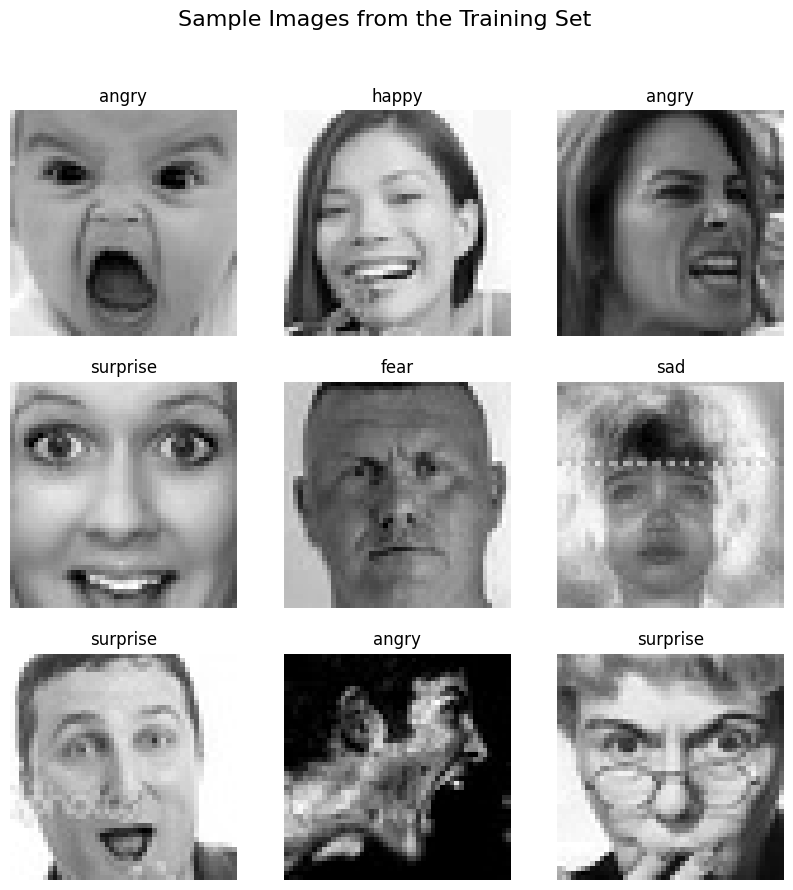

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


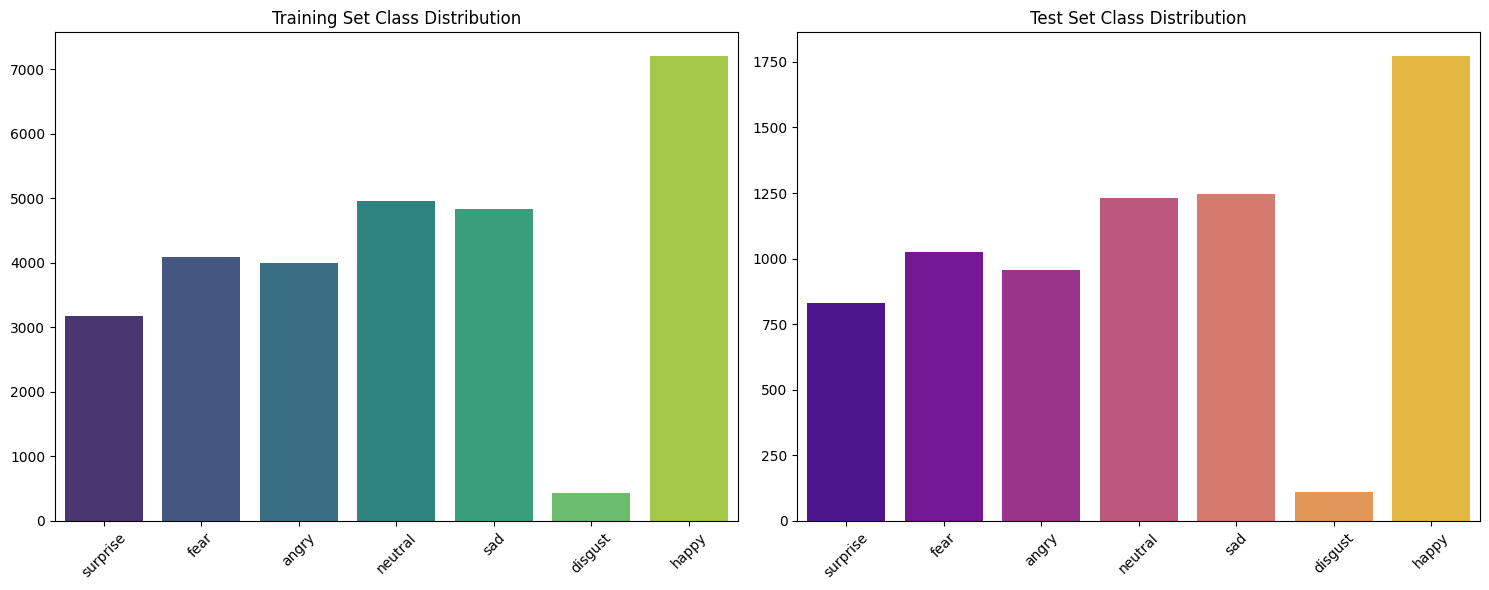

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Sample Images from the Training Set", size=16)
plt.show()


def get_class_distribution(directory):
    dist = {}
    for emotion_folder in os.listdir(directory):
        dist[emotion_folder] = len(os.listdir(os.path.join(directory, emotion_folder)))
    return dist

train_dist = get_class_distribution(TRAIN_DIR)
test_dist = get_class_distribution(TEST_DIR)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=list(train_dist.keys()), y=list(train_dist.values()), ax=ax1, palette='viridis')
ax1.set_title('Training Set Class Distribution')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_title('Test Set Class Distribution')
sns.barplot(x=list(test_dist.keys()), y=list(test_dist.values()), ax=ax2, palette='plasma')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential([
    # Input layer with normalization
    Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    # Flattening
    Flatten(),

    # Fully Connected Layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

print("Starting model training...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)
print("\nModel training completed!")

Starting model training...
Epoch 1/50


I0000 00:00:1751060827.291499     120 service.cc:148] XLA service 0x79cef4008d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751060827.297262     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751060827.297284     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751060828.400452     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/359 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.1719 - loss: 3.3591   

I0000 00:00:1751060839.061112     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step - accuracy: 0.2499 - loss: 2.3874 - val_accuracy: 0.0056 - val_loss: 3.1384 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4025 - loss: 1.6125 - val_accuracy: 0.4551 - val_loss: 1.6312 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.4848 - loss: 1.3538 - val_accuracy: 0.5046 - val_loss: 1.3768 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.5345 - loss: 1.2296 - val_accuracy: 0.4363 - val_loss: 1.4980 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5595 - loss: 1.1613 - val_accuracy: 0.5901 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5928 - loss: 1.0798 - val_accuracy: 0.5887 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.6026 - loss: 1.053

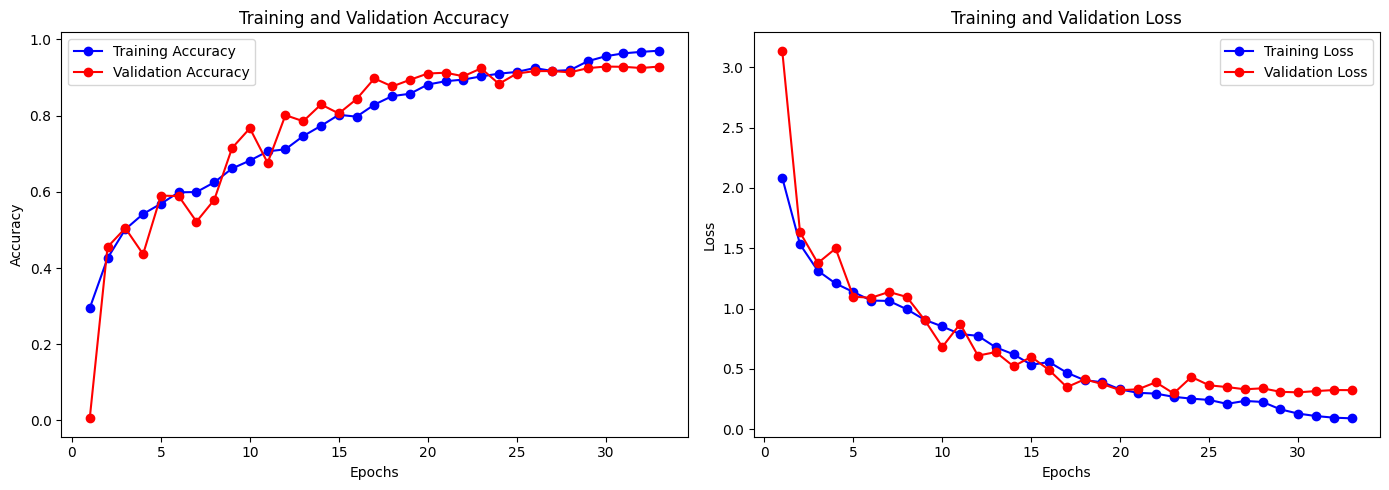


Test Accuracy: 62.96%
Test Loss: 1.4676
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.54      0.55       958
     disgust       0.93      0.50      0.65       111
        fear       0.54      0.39      0.45      1024
       happy       0.86      0.81      0.83      1774
     neutral       0.55      0.60      0.57      1233
         sad       0.45      0.60      0.52      1247
    surprise       0.77      0.76      0.77       831

    accuracy                           0.63      7178
   macro avg       0.67      0.60      0.62      7178
weighted avg       0.64      0.63      0.63      7178



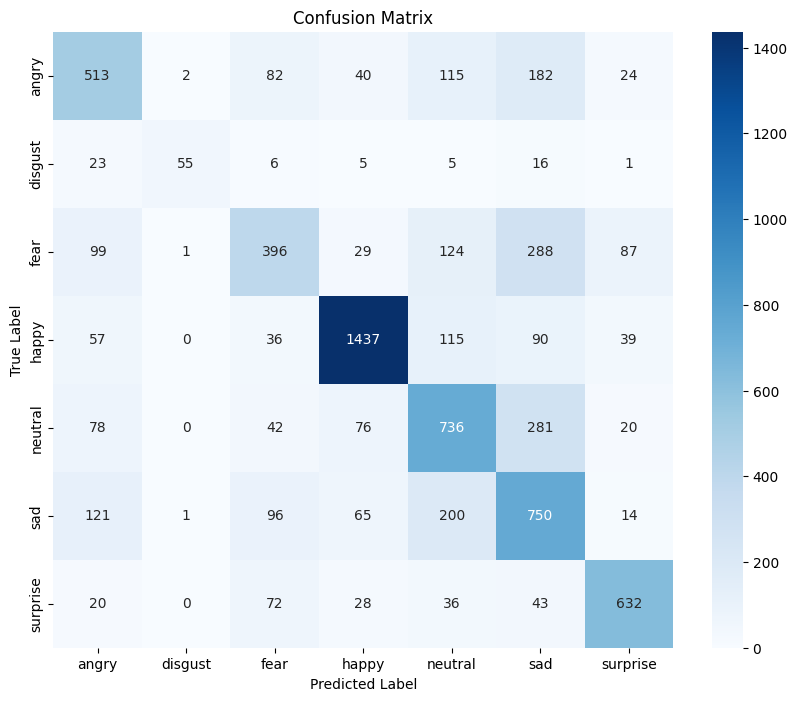

In [ ]:

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_training_history(history)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0) # Extract true labels from the dataset
y_true = np.argmax(y_true, axis=1)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save the model to a file
model_filename = "emotion_detection_model_v2.h5"
model.save(model_filename)

print(f"Model saved successfully as '{model_filename}'")


Model saved successfully as 'emotion_detection_model_v2.h5'
